- 아무 adaptation 없는 pretrained model에 cifar10 train data, cifar10 test data, cifar 10c test data등을 넣고 나오는 penultimate layer statistic 비교

In [1]:
from __future__ import division, print_function, absolute_import
import argparse
import yaml
import time
from nets import MNISTCNNBase, ResNet18, learner_distances, add_stats_layer_to_resnet_named_modules, \
    add_stats_layers_to_cnn_classifier, add_stats_layers_to_cnn_everywhere
import nets_wilds
from lib.utils import *
from lib.stats_layers import *
from lib.data_utils import get_static_emnist_dataloaders, get_static_emnist_dataloaders_fewshot, \
    get_cifar10c_dataloaders, get_cifar100c_dataloaders, per_hospital_wilds_dataloader, \
    per_hospital_wilds_dataloader_fewshot
from data.digits import *

In [2]:
# 뭐랑 뭐를 비교하고 싶은지에 따라 다름 (cifar10, cifar10test, cifar10c)
source_dataset_name = "cifar10test"
target_dataset_name = "cifar10c"
output_dir = "."
n_classes = 10
stats_layers = ["bins"]
dev=torch.device('cpu')
seeds = 123 

source_ckpt_dir = os.path.join(output_dir, "ckpts", source_dataset_name)
target_ckpt_dir = os.path.join(output_dir, "ckpts", target_dataset_name)

In [3]:
learner = ResNet18(n_classes=n_classes)
modules_to_track = ['linear']
module_features_out = [n_classes]
module_features_in = [512]

for stats_layer in stats_layers:
    add_stats_layer_to_resnet_named_modules(learner, modules_to_track, module_features_out,
                                            module_features_in, stats_layer_type=stats_layer,
                                            surprise_score="PSI",
                                            tau=0.01)
    for learner_stats_layer in learner.stats_layers:
        learner_stats_layer.calc_surprise = True
    learner_stats_layers = learner.stats_layers


In [7]:
# raw bin count이기 때문에 distribution이라기보다는 아직 bin count
def get_distribution(ckpt_dir, class_num):

    ckpt_name = get_ckpt_name(200, "resnet18", 123, "bins", f'0.01_{class_num}')
    _, p_model = load_ckpt('pretrain-learner', learner, os.path.join(ckpt_dir, ckpt_name), dev)
    distribution = p_model.linear[0].bin_counts.detach().clone().cpu().numpy()

    # distribution = ndarray((class_num, 10))
    return distribution

def vis_histogram(source_ckpt_dir, target_ckpt_dir, class_num, feat_index):
    source_d = get_distribution(source_ckpt_dir, class_num)
    target_d = get_distribution(target_ckpt_dir, class_num)
    source_d /= source_d.sum()
    target_d /= target_d.sum()
    plt.plot(source_d[feat_index], label="source")
    plt.plot(target_d[feat_index], label="target")
    plt.legend()


In [16]:
# get sum of divergence (source 1 vs source 2) + ... + (source N-1 vs source N) 
# or same thing for target
def get_sum_divergence(ckpt_dir):
    sum_divergence = np.zeros(module_features_in[0])

    for class_p in range(n_classes):
        for class_q in range(n_classes):

            # 오짜피 0이여서 상관없긴 함
            if class_p==class_q:
                continue

            p_distribution = get_distribution(ckpt_dir, class_p)
            q_distribution = get_distribution(ckpt_dir, class_q)

            #divergence.shape : (num_features,) class_p에서와 class_q
            #QUESTION: fast랑 slow가 정확히 어떻게 다르지?
            divergence = surprise_bins(p_distribution, q_distribution, score_type="PSI", fast=True)
            sum_divergence += divergence

    return sum_divergence

# get sum of divergence (source 1 vs target 1) + ... + (source N vs target N)
def get_sum_divergence_st(source_ckpt_dir, target_ckpt_dir):
    sum_divergence = np.zeros(module_features_in[0])

    for class_idx in range(n_classes):

        p_distribution = get_distribution(source_ckpt_dir, class_idx)
        q_distribution = get_distribution(target_ckpt_dir, class_idx)

        #divergence.shape : (num_features,) class_p에서와 class_q
        #QUESTION: fast랑 slow가 정확히 어떻게 다르지?
        divergence = surprise_bins(p_distribution, q_distribution, score_type="PSI", fast=True)
        sum_divergence += divergence

    return sum_divergence

In [10]:
source_divergence = get_sum_divergence(source_ckpt_dir)
target_divergence = get_sum_divergence(target_ckpt_dir)

Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_4.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_5.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.0

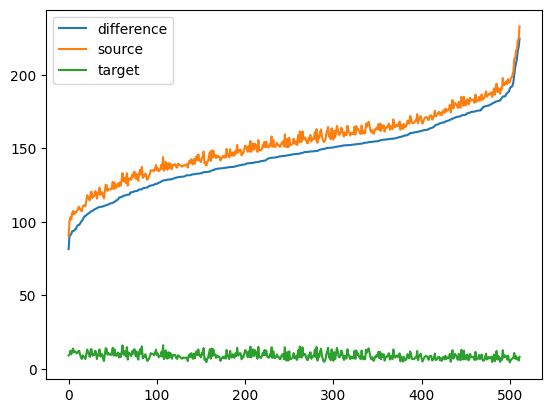

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

diff = source_divergence - target_divergence
diff_index=np.argsort(diff)

plt.plot(diff[diff_index], label="difference")
plt.plot(source_divergence[diff_index],  label="source")
plt.plot(target_divergence[diff_index], label="target")
plt.legend()


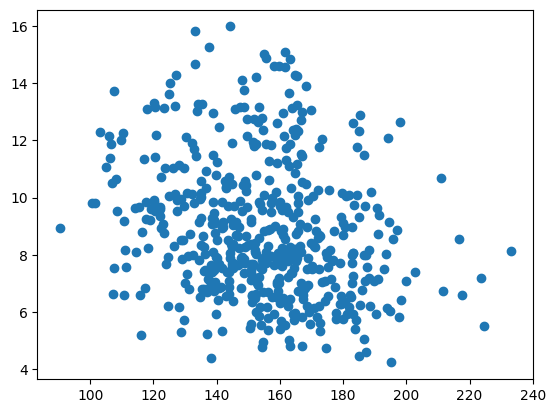

In [12]:
plt.scatter(source_divergence, target_divergence)

Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_4.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_4.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_5.pth.tar
Loa

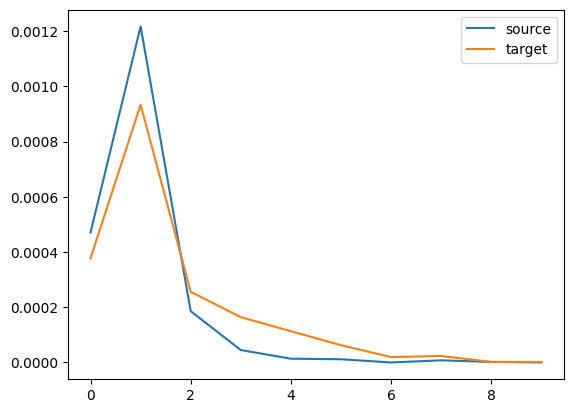

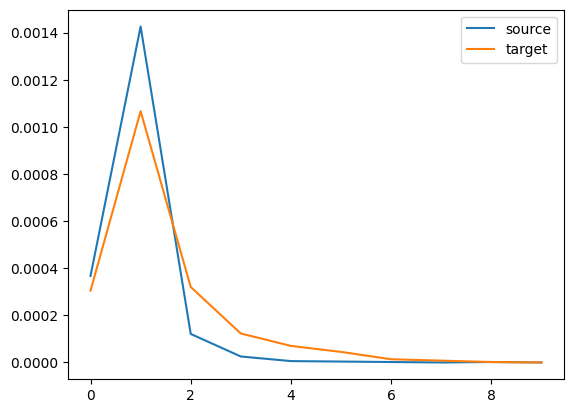

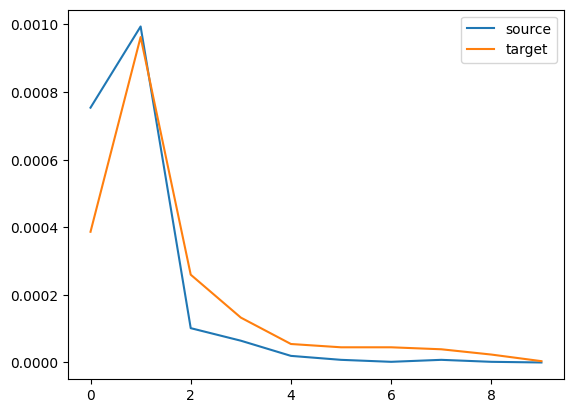

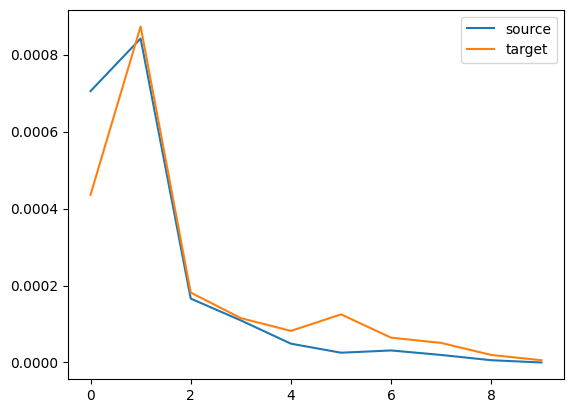

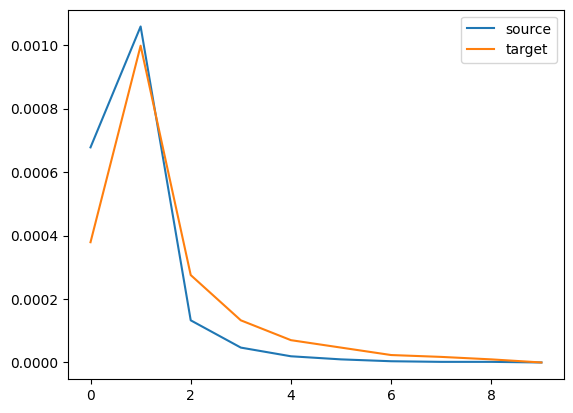

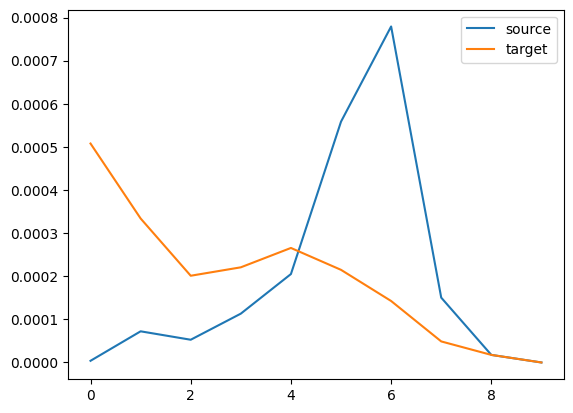

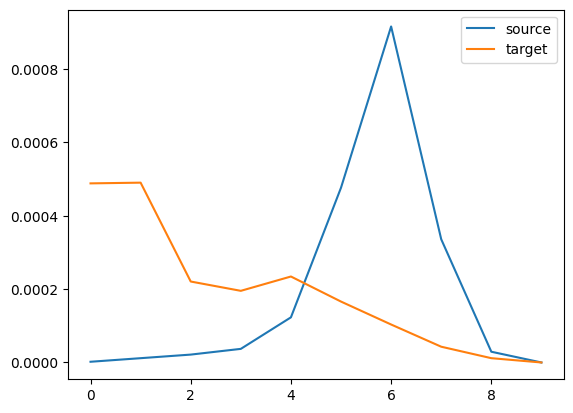

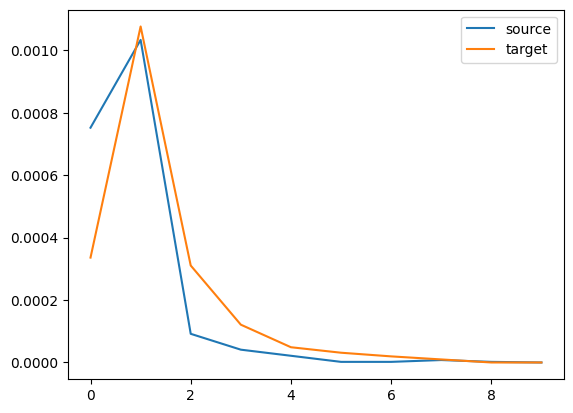

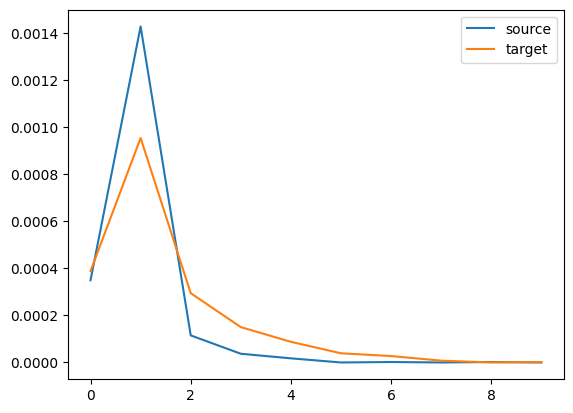

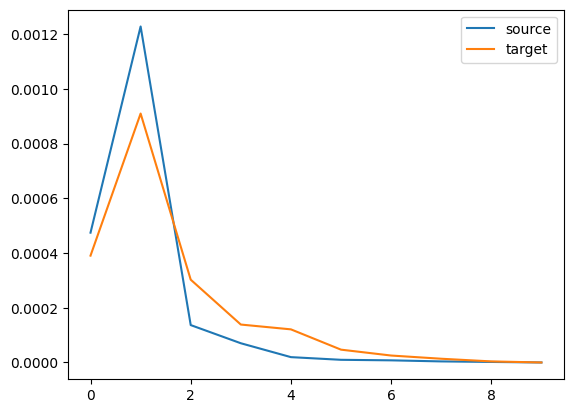

In [15]:
for class_num in range(10):
    plt.figure(class_num)
    vis_histogram(source_ckpt_dir, target_ckpt_dir, class_num=class_num, feat_index=1)

In [17]:
total_divergence = get_sum_divergence_st(source_ckpt_dir, target_ckpt_dir)

Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_4.pth.tar
Loaded model from ./ckpts/cifar10c/pretrain-learner-200_resnet18_123_bins_0.01_4.pth.tar
Loaded model from ./ckpts/cifar10test/pretrain-learner-200_resnet18_123_bins_0.01_5.pth.tar
Loa

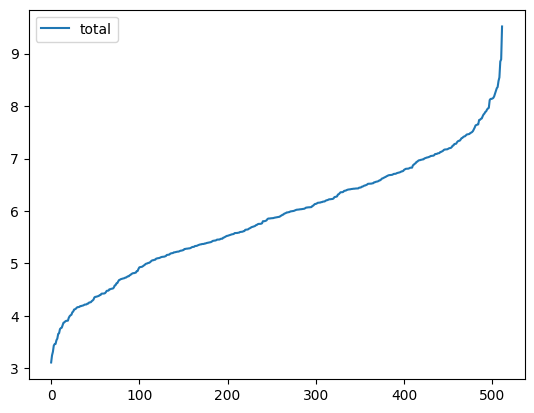

In [20]:
total_divergence.sort()
plt.plot(total_divergence, label="total")
plt.legend()